<a href="https://colab.research.google.com/github/dabeyrathna/Generative-Adversarial-Networks/blob/main/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, Dropout, UpSampling2D, Conv2DTranspose, Conv2D, LeakyReLU, Flatten, Input
from keras.layers import Activation, ZeroPadding2D
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.datasets import mnist
import time
import os

!mkdir 'images'

In [ ]:
def discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(256, (5,5), strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1,activation='sigmoid'))
  im = Input(shape=(28,28,1))
  val = discriminator(im)
  return Model(im,val)

def generator():
  generator = Sequential()
  units = 7 * 7* 192
  generator.add(Dense(units, input_dim=100))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(layers.ReLU())
  generator.add(Reshape((7,7,192)))
  generator.add(Dropout(0.4))
  generator.add(UpSampling2D())
  generator.add(Conv2D(96, (5,5), strides=(1,1), padding='same'))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(layers.ReLU())
  generator.add(UpSampling2D())
  generator.add(Conv2D(48, (5,5), strides=(1,1), padding='same'))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(layers.ReLU())
  generator.add(Conv2D(24, (5,5), strides=(1,1), padding='same'))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(layers.ReLU())
  generator.add(Conv2D(1, (5,5), strides=(1,1), padding='same'))
  generator.add(tf.keras.layers.Activation('sigmoid'))
  noise = Input(shape=(100,))
  img = generator(noise)
  return Model(noise, img)


In [ ]:
# img_rows = 28
# img_cols = 28
# channels = 1
# img_shape = ( 28, 28,1)
# latent_dim = 100



<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49384224]], dtype=float32)>

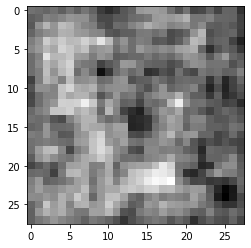

In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

generator = generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
z = Input(shape=(100,))
img = generator(z)

# plt.imshow(img,cmap='gray')
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
discriminator(generated_image)

In [ ]:
dLosses = []
dfLosses = []
gLosses = []



In [ ]:
def gan(gen, disc):
	disc.trainable = False
	gan = Sequential()
	gan.add(gen)
	gan.add(disc)
	gan.compile(loss='binary_crossentropy', optimizer=optimizer)
	return gan

def discmodel():
	optimizer = Adam(0.0002, 0.5)
	disc = discriminator()
	disc.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
	return disc


In [ ]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
X_train = (X_train.astype('float32') - 128)/128
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

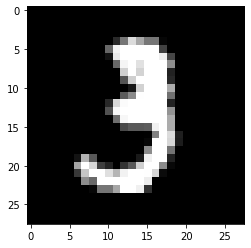

In [ ]:
plt.imshow(X_train[10,:,:,0],cmap='gray')

In [ ]:
def train(epochs, batch_size=128, save_interval=50):
    os.makedirs('images', exist_ok=True)

    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

    X_train = X_train / 255.
    X_train = np.expand_dims(X_train, axis=3)
    plt.imshow(X_train[0,:,:,0],cmap='gray')

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        plt.imshow(real_imgs[0,:,:,0],cmap='gray')
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_imgs = generator.predict(noise)

        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        g_loss = combined.train_on_batch(noise, valid)

        dLosses.append(D_loss)
        # dfLosses.append(D_loss_fake)
        gLosses.append(g_loss)

        if epoch % save_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            save_imgs(epoch)

    plottheloss(epoch)

In [ ]:
def train1(epochs=1, batchSize=128):
    os.makedirs('images', exist_ok=True)
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            noise = np.random.normal(0, 1, size=(batchSize, 100))
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            generatedImages = generator.predict(noise)
            # print(X_train.shape)
            # print(imageBatch.shape)
            # print(generatedImages.shape)

            X = np.concatenate([imageBatch, generatedImages])
            
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9

            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            noise = np.random.normal(0, 1, size=[batchSize, 100])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            # print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, dloss[0], 100 * dloss[1], gloss))
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, dloss[0], 100 * dloss[1], gloss))

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            save_imgs(e)

    plottheLoss(e)

In [ ]:
def save_imgs(epoch):
    r, c = 6, 6
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [ ]:

def plottheloss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='D loss')
    #plt.plot(dfLosses, label='Discriminitive Fake loss')
    plt.plot(gLosses, label='G loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/g_loss_epoch_%d.png' % epoch)

In [ ]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

0 [D loss: 0.714040, acc.: 6.25%] [G loss: 0.695737]
10000 [D loss: 0.638467, acc.: 64.06%] [G loss: 0.764251]
20000 [D loss: 0.676241, acc.: 54.69%] [G loss: 0.816598]
30000 [D loss: 0.646939, acc.: 59.38%] [G loss: 0.808608]
40000 [D loss: 0.618369, acc.: 68.75%] [G loss: 0.809657]
50000 [D loss: 0.687880, acc.: 51.56%] [G loss: 0.776760]


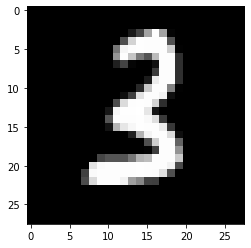

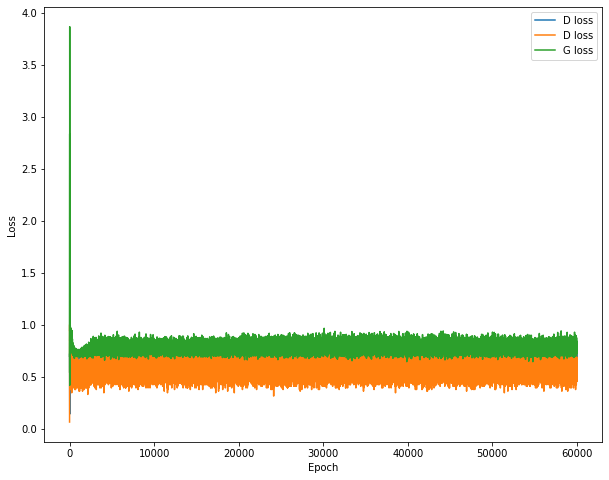

In [ ]:
import os
# start = time.time()

train(epochs=60000, batch_size=32, save_interval=10000)
# train1(100,32)
# end = time.time()
# elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                    #  int((end - start) % 60))
# print(elapsed_train_time)

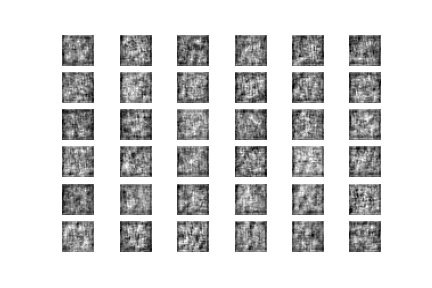

In [ ]:
Image.open('images/mnist_0.png')

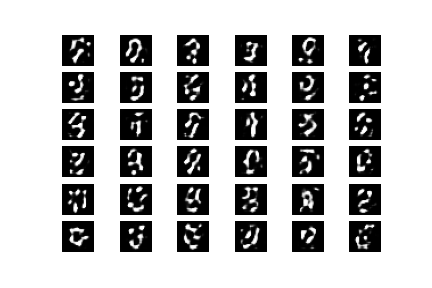

In [ ]:
Image.open('images/mnist_200.png')

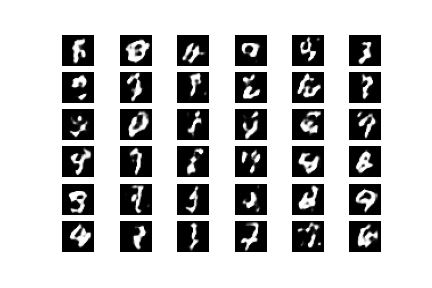

In [ ]:
Image.open('images/mnist_400.png')

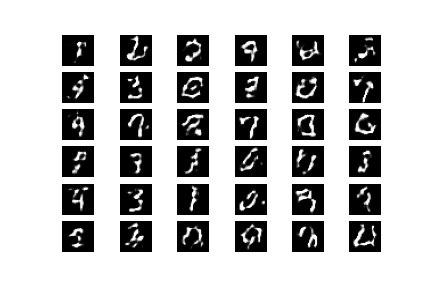

In [ ]:
Image.open('images/mnist_600.png')

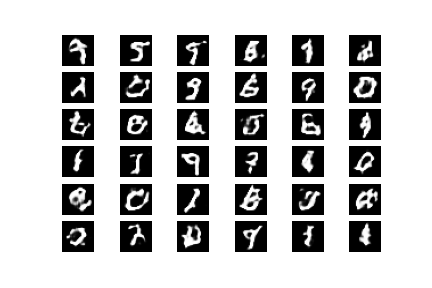

In [ ]:
Image.open('images/mnist_800.png')

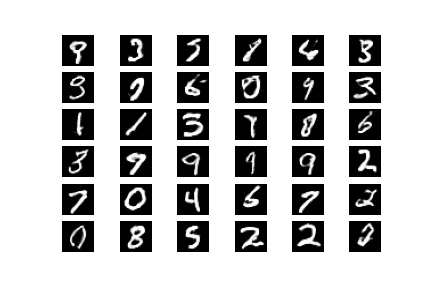

In [ ]:
Image.open('images/mnist_20000.png')